# Training using modifiec loss function

After discussion with Hsuan-Tien and Yu-Wen, two possible solutions I can try are:
1.  Reduce the distance between the max and minimum of the spectral counts. Recommended ways are:
    -   Use the log of the spectral counts
    -   Standardize the spectral counts (Z score)
1.  Modify the loss function to be more aggresive on the high spectral counts, whcih are much rare than low councts (i.e. data imbalance). This may harmonize the model's preference on predicting moderate counts.
    -   BTW, the higher predicted spectral counts in the unmasked low value parts may be solved by including the loss of those unmasked parts. Since the mask ratio is pretty high and our observed phenomenon, counting only loss on the masked parts is not necessary.

In this notebook, I will express the results of the second solution. Since I am not totally convinced to use whether standardization or logrithm, I apply the modified loss on them both. The loss is the same as the MAE, but include the unmasked parts. Hopefully, this can eliminate the bad performance on the unmasked parts.

## Functions

In [32]:
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from util.datasets import CustomImageDataset, log_transform, standardize
import matplotlib.pyplot as plt
import pandas as pd

def get_dataloader(batch_size: int, transform=None):
    dataset = CustomImageDataset('data/info_20231121.csv', 'data/spe', transform=transform)
    data_train, data_val = random_split(dataset, [0.8, 0.2], generator=torch.manual_seed(24))
    dataloader = {
        'train':DataLoader(data_train, batch_size=batch_size, shuffle=True),
        'val':DataLoader(data_val, batch_size=batch_size, shuffle=True)
        }
    return dataloader

def eval(model, spe_arr):
    model.eval()
    with torch.no_grad():
        torch.manual_seed(24)
        spe = torch.from_numpy(spe_arr)
        return model(spe.unsqueeze(0).float())
    
def unpatchify(mask, pred, model):
    pred_un = model.unpatchify(pred)
    pred_un_arr = pred_un.squeeze(0).numpy()

    mask_arr = mask.squeeze(0).numpy()
    mask_un_arr = np.array([])
    for i in mask_arr:
        mask_un_arr = np.concatenate((mask_un_arr, np.repeat(i, 16)))
    mask_un_arr = mask_un_arr.astype(int)

    return pred_un_arr, mask_un_arr

def plot_spectrum(spe_arr, pred_un_arr, mask_un_arr):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    channel = np.arange(1, len(spe_arr)+1)
    ax.vlines(channel, ymin=0, ymax=mask_un_arr*spe_arr.max(), color='gray', alpha=0.3, label='masked')
    ax.plot(channel, spe_arr, alpha=.8, label='raw')
    ax.plot(channel, pred_un_arr, alpha=.6, label='pred')
    ax.set_xlim(-1, 2050)
    #ax.set_ylim(0, spe_arr.max())
    ax.set_ylabel('ln(counts)')

    ax.set_xlabel('Channel')
    ax.legend()
    plt.show()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def print_loss(spe_arr, pred_un_arr, mask_un_arr):
    # 0: unmasked, 1: masked
    # spe_arr: raw spectrum array
    # pred_un_arr: unpatchfied predicted spectrum array
    # mask_un_arr: unpatchfied mask array
    print(
            'loss of the masked part ({}): {:.3f}'.format(
                mask_un_arr.sum(),
                ((pred_un_arr - spe_arr)**2 * mask_un_arr).sum() / mask_un_arr.sum()
            )
    )
    print(
            'loss of the unmasked part ({}): {:.3f}'.format(
                (mask_un_arr==0).sum(),
                ((pred_un_arr - spe_arr)**2 * (mask_un_arr==0)).sum() / (mask_un_arr==0).sum()
            )
)

std
             lr  min_val_loss
0  1.000000e-03      0.857445
1  1.000000e-04      0.017216
2  1.000000e-05      0.008004
3  1.000000e-06      0.059247
4  1.000000e-07      0.451711
ln
             lr  min_val_loss
0  1.000000e-03      0.184880
1  1.000000e-04      0.045720
2  1.000000e-05      0.050580
3  1.000000e-06      0.106071
4  1.000000e-07      0.642960


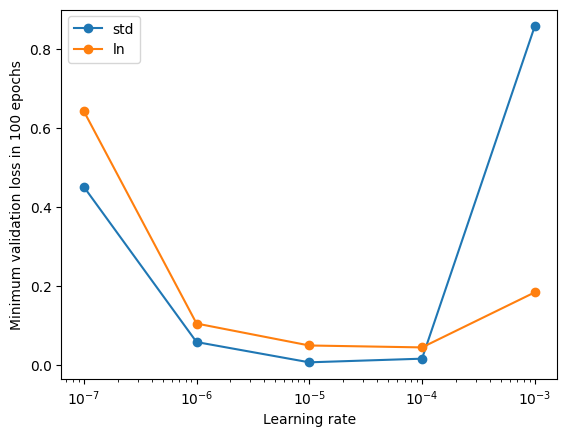

In [5]:
for data in ['std', 'ln']:
    lr_df = pd.read_csv(f'results/{data}/test_lr_20231212.csv')
    print(data)
    print(lr_df)
    plt.plot(lr_df.lr, lr_df.min_val_loss, 'o-', label=data)
    plt.xscale('log')
    plt.xlabel('Learning rate')
    plt.ylabel('Minimum validation loss in 100 epochs')
plt.legend()


The best learning rate for std and ln is 1e-05 and 1e-04, respectively. This is the same as the model using the original loss function.

Be aware that the loss of these two models are in different space, so they can not be compared directly.

### Standardization

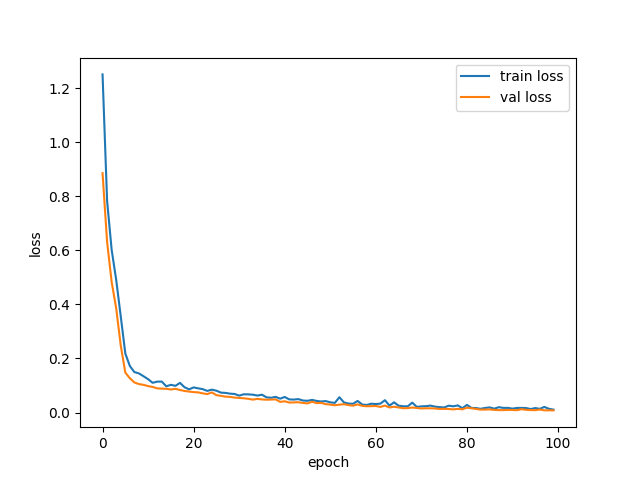

In [10]:
from IPython.display import Image
Image(filename='results/std/loss_1e-05_20231212.png')

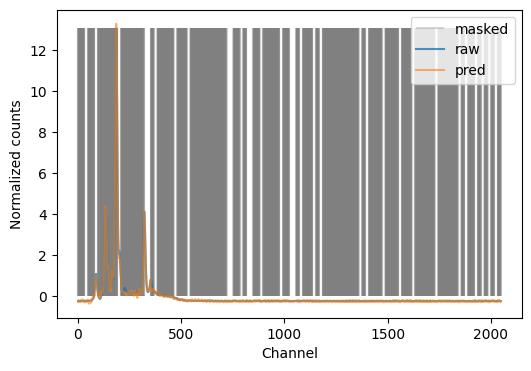

In [38]:
from models_mae_loss import mae_vit_base_patch16
model = mae_vit_base_patch16()
model.load_state_dict(torch.load('models/mae_vit_base_patch16_std_1e-05_20231212.pth'))

dataloader = get_dataloader(batch_size=64, transform=standardize)
# inference on the validation set
spe_arr = dataloader['val'].dataset[60]

loss, pred, mask = eval(model, spe_arr)
pred_un_arr, mask_un_arr = unpatchify(mask, pred, model)
plot_spectrum(spe_arr, pred_un_arr, mask_un_arr)

In [39]:
print_loss(spe_arr, pred_un_arr, mask_un_arr)

loss of the masked part (1536): 0.006
loss of the unmasked part (512): 0.003


### Log transform

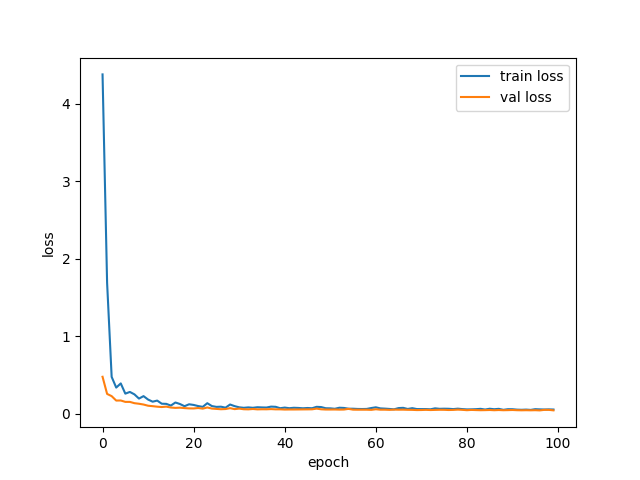

In [ ]:
from IPython.display import Image
Image(filename='results/ln/loss_0.0001_20231212.png')

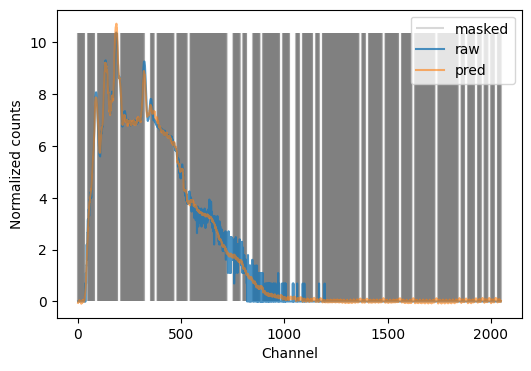

In [40]:
from models_mae import mae_vit_base_patch16
model = mae_vit_base_patch16()
model.load_state_dict(torch.load('models/mae_vit_base_patch16_ln_0.0001_20231212.pth'))

dataloader = get_dataloader(batch_size=64, transform=log_transform)
# inference on the validation set
spe_arr = dataloader['val'].dataset[60]

loss, pred, mask = eval(model, spe_arr)
pred_un_arr, mask_un_arr = unpatchify(mask, pred, model)
plot_spectrum(spe_arr, pred_un_arr, mask_un_arr)

In [41]:
print_loss(spe_arr, pred_un_arr, mask_un_arr)

loss of the masked part (1536): 0.036
loss of the unmasked part (512): 0.072


The bad performance at the unmasked parts is gone in both normalization methods.

## Compare the loss
In order to compare, the loss from three different models are calculated in the raw spectral counts and using a spectrum from the validation set.
### Functions

In [42]:
def plot_spectrum(spe_arr, pred_un_arr, mask_un_arr, ymax=30):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    scale = .001
    channel = np.arange(1, len(spe_arr)+1)
    for ax in axes:
        if ax == axes[0]: # normal view
            # I don't use ax.bar because it has issue on drawing at the exact positions
            # when the drawing density is too high due to the small figure size
            # this issue disappears when the figure size is large enough or zoom in
            ax.vlines(channel, ymin=0, ymax=mask_un_arr*(spe_arr.max()*scale), color='gray', alpha=0.3, label='masked')
            ax.plot(channel, spe_arr*scale, alpha=.8, label='raw')
            ax.plot(channel, pred_un_arr*scale, alpha=.6, label='pred')
            ax.set_xlim(-1, 2050)
            #ax.set_ylim(0, spe_arr.max()*scale)
            ax.set_ylabel('Counts (K)')
        else: # zoom in
            ax.vlines(channel, ymin=0, ymax=mask_un_arr*ymax, color='gray', alpha=0.3, label='masked')
            ax.plot(channel, spe_arr, alpha=.8, label='raw')
            ax.plot(channel, pred_un_arr, alpha=.6, label='pred')
            
            ax.set_ylim(0, ymax)
            ax.set_ylabel('Counts')
            ax.set_xlim(-1, 2050)

        ax.set_xlabel('Channel')
        ax.legend()
    plt.show()

In [44]:
model = {}
spe_arr = {}
pred_un_arr = {}
data_list = ['raw', 'std', 'ln']
transform_list = [None, standardize, log_transform]
state_list = [
    'models/mae_vit_base_patch16_0.01_20231207.pth',
    'models/mae_vit_base_patch16_std_1e-05_20231212.pth',
    'models/mae_vit_base_patch16_ln_0.0001_20231212.pth'
]

for data, transform, state in zip(data_list, transform_list, state_list):
    print(data)
    # read model
    model[data] = mae_vit_base_patch16()      
    model[data].load_state_dict(torch.load(state))

    # read data
    dataloader = get_dataloader(batch_size=64, transform=transform)
    spe_arr[data] = dataloader['val'].dataset[60]

    # inference
    loss, pred, mask = eval(model[data], spe_arr[data])
    pred_un_arr[data], mask_un_arr = unpatchify(mask, pred, model[data])

# transform back
mean = spe_arr['raw'].mean()
std = spe_arr['raw'].std()

pred_un_arr['std'] = pred_un_arr['std'] * std + mean
pred_un_arr['ln'] = np.exp(pred_un_arr['ln']) - 1 
# I forgot to -1 in pilot_08.ipynb, but it's effect is really minor


raw
std
ln


raw
loss of the masked part (1536): 2625933.065
loss of the unmasked part (512): 2694258.278


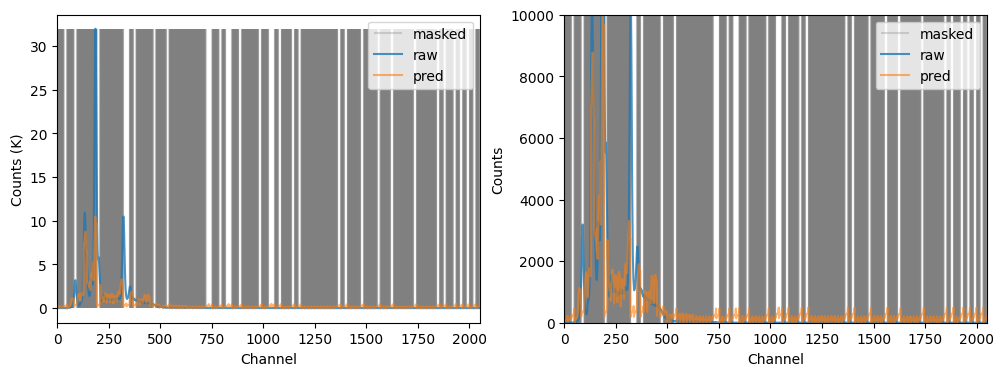

std
loss of the masked part (1536): 36719.963
loss of the unmasked part (512): 16493.621


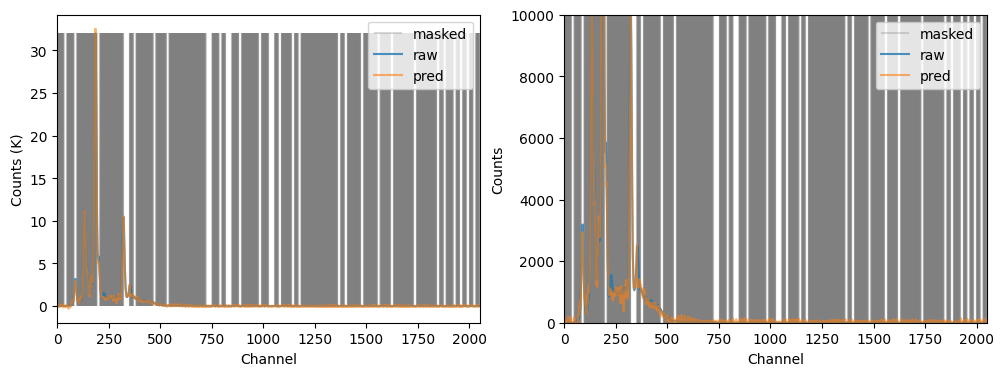

ln
loss of the masked part (1536): 919907.169
loss of the unmasked part (512): 242670.439


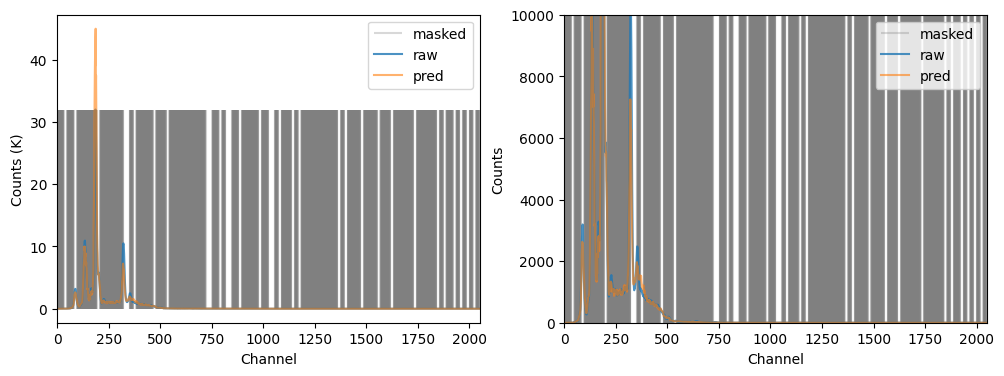

In [45]:
for data in data_list:
    print(data)
    print_loss(spe_arr['raw'], pred_un_arr[data], mask_un_arr)
    plot_spectrum(spe_arr['raw'], pred_un_arr[data], mask_un_arr, ymax=1e4)

In [46]:
print('Total loss')
print(f'No transform: {2625933.065+2694258.278}')
print(f'Standardization: {36719.963+16493.621}')
print(f'Log transform: {919907.169+242670.439}')

Total loss
No transform: 5320191.343
Standardization: 53213.584
Log transform: 1162577.608


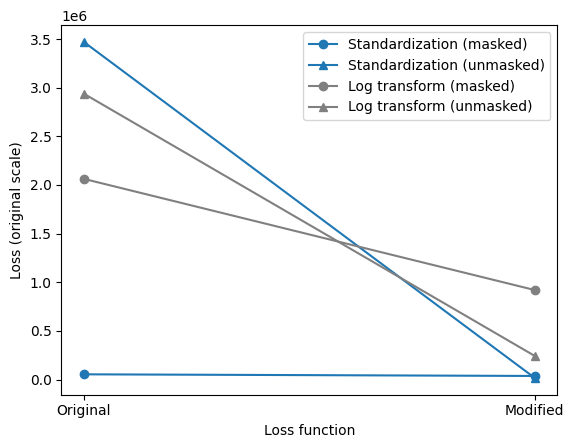

In [47]:
version = ['Original', 'Modified']
std_mask = [53531.350, 36719.963]
ln_mask = [2062529.071, 919907.169]
std_unmask = [3470196.793, 16493.621]
ln_unmask = [2938124.379, 242670.439]


plt.plot(version, std_mask, 'o-', label='Standardization (masked)', c='C0')
plt.plot(version, std_unmask, '^-', label='Standardization (unmasked)', c='C0')
plt.plot(version, ln_mask, 'o-', label='Log transform (masked)', c='gray')
plt.plot(version, ln_unmask, '^-', label='Log transform (unmasked)', c='gray')
plt.ylabel('Loss (original scale)')
plt.xlabel('Loss function')
plt.legend()

## Discussion
I'll discuss in three perspectives as well:

**Total loss**: The standardization still gives the best loss, which is only ~1.5% of its model with the original loss and ~4.5% of the log transform model with modified loss. 

**Loss in masked/unmasked parts**: **My assumption comes true.** With the modified loss, the loss of unmasked parts is reduced to the same order of the loss of masked parts. And the loss of masked parts is even getting lower comparing to its model with the original loss. In contrast, the loss of unmasked parts in the log transform model is still very high. It is about 4 times of the loss of masked parts. Overall, the loss of the log transform model decreases comparing to its predecessor (masked: ~44%; unmasked: ~8%), but not as much as the standardize model (masked: ~69%; unmasked: ~0.5%).

**Predicted spectral pattern**: It's a rather subjective evaluation. After reduing the noisy loss that standardize model had with the original loss, the predicted spectral pattern looks better than the log transform model. This fits more to the loss.

Based on the above discussion, I will use the standardization method in the following training.